# F. Analyse sentiment by sentence
## Import necessary libraries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [6]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [7]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [8]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load and process input data

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [10]:
if IN_COLAB:
    preprocessed_dir = 'drive/My Drive/Colab Data/'
    train_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
    model_dir = 'drive/My Drive/Colab Data/'
else:
    preprocessed_dir = '../data/preprocessed/'
    train_dir = '../data/train_data/'
    output_dir = '../data/result/'
    lmdict_dir = '../data/LoughranMcDonald/'
    glove_dir = '../data/GloVe'
    model_dir = '../data/models/'

In [11]:
# Load previously processed non-text data
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
meta_df = pickle.load(file)
file.close()

print(meta_df.shape)
meta_df


(398, 10)


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
1983-01-28,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
1983-02-09,0,0,0.039942,46.0,102.0,1.807631,0.000000,-0.091455,6.403612,0.003723
1983-03-29,1,0,0.039942,54.4,73.0,1.807631,0.133333,-0.104496,13.270610,0.003723
1983-04-29,0,1,0.039942,53.9,50.0,1.807631,0.166667,0.076200,20.486913,0.003723


In [12]:
# List of Non-text columns
meta_columns = meta_df.drop(columns=['target']).columns.tolist()
meta_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [13]:
# Load text data
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


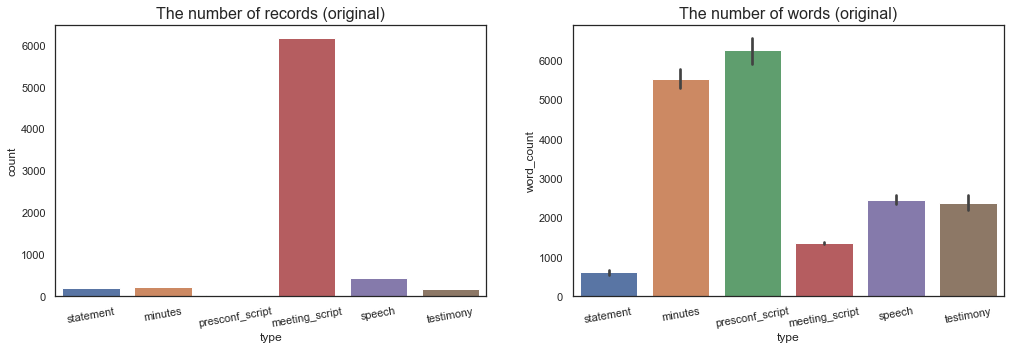

In [14]:
# Check the number of records per document type
def plot_num_rec_word(df):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)
    
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.5,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


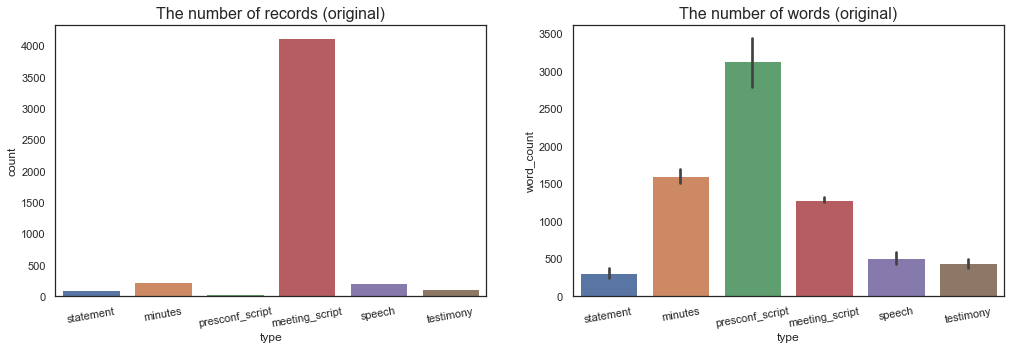

In [15]:
plot_num_rec_word(text_keyword)
text_keyword.head()

In [16]:
# # Drop meeting script data
# text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
# text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
# text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe

(1068, 11)



(1268, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


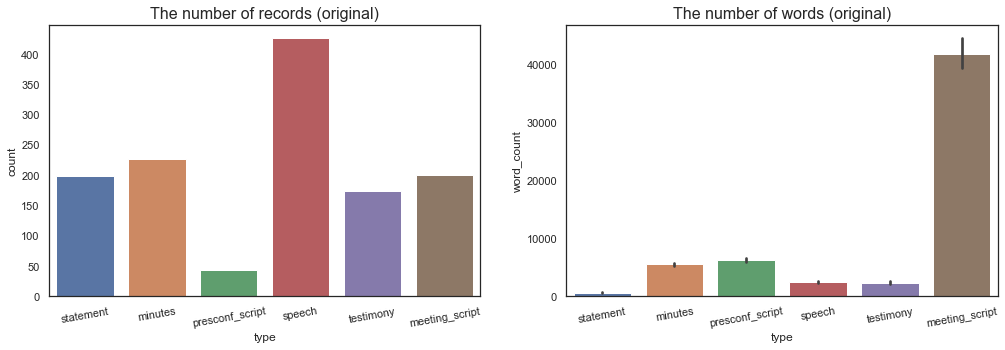

In [17]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row
            
    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

/Users/yuki/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


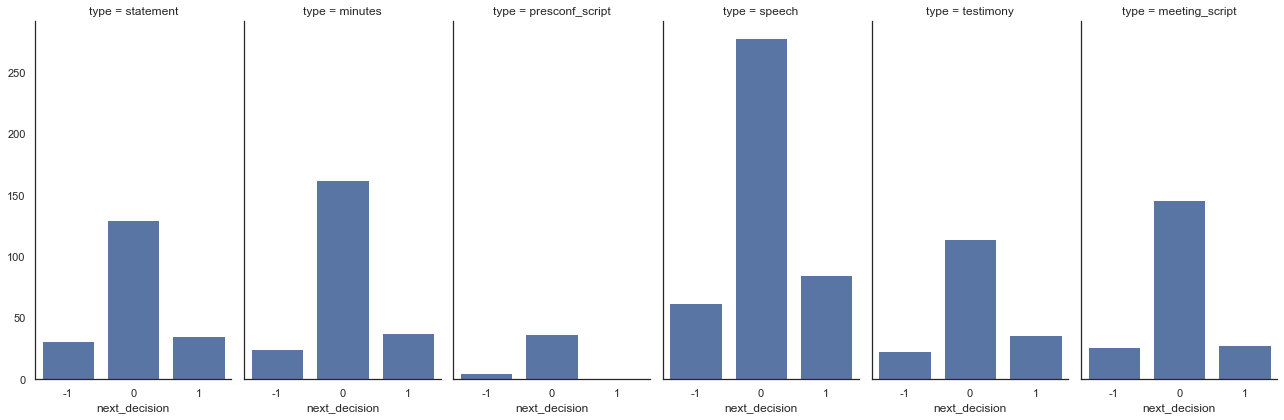

In [18]:
# Check balance of Rate Decision
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


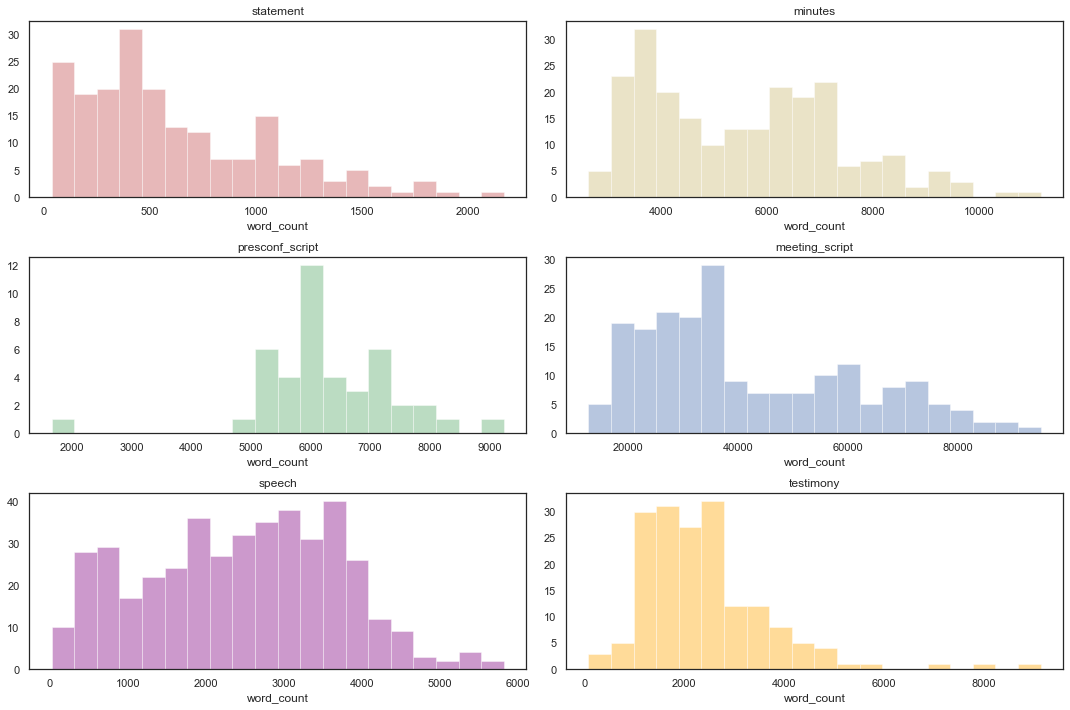

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
195,meeting_script,2014-06-18,FOMC Meeting Transcript,,82139,0,0,2014-07-30,0,0.0,Thank you. Vice Chairman. me to begin w...
196,meeting_script,2014-07-30,FOMC Meeting Transcript,,83864,0,0,2014-09-17,0,0.0,All of this is exactly right. It is indeed o...
197,meeting_script,2014-09-17,FOMC Meeting Transcript,,59881,0,0,2014-10-29,0,0.0,"Good morning, everybody. Our first two items ..."
198,meeting_script,2014-10-29,FOMC Meeting Transcript,,68898,0,0,2014-12-17,0,0.0,I’d like to call this meeting to order. Befo...
199,meeting_script,2014-12-17,FOMC Meeting Transcript,,55886,0,0,2015-01-28,0,0.0,"Good afternoon, everyone. I think we are rea..."


In [19]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


In [20]:
# Add a key for aggregation
train_df['key'] = train_df.index.get_level_values(0)
train_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,1
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,2
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",3
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",4


## Split each text by sentence

In [21]:
# Split the data by sentence
def split_df(df, text_column='text'):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

train_sent_df = split_df(train_df)
print(train_sent_df.shape)


(482025, 12)


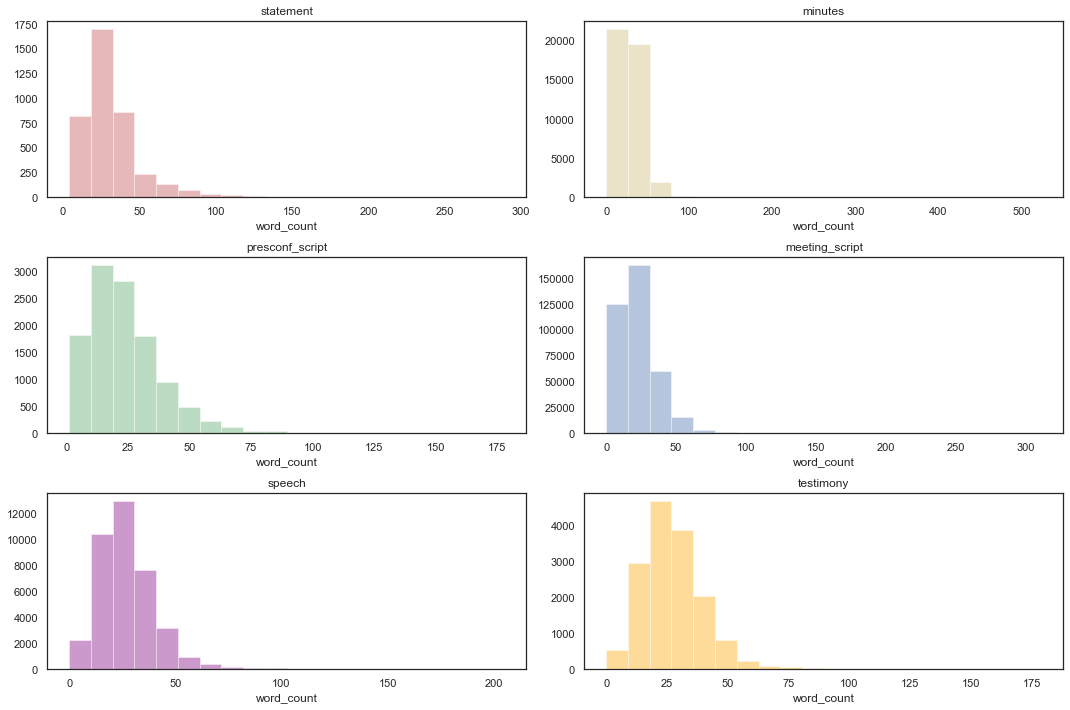

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
482020,meeting_script,2014-12-17,FOMC Meeting Transcript,,19,0,0.0,2015-01-28,0,0.0,"In other words, there’s not a requirement that...",199
482021,meeting_script,2014-12-17,FOMC Meeting Transcript,,17,0,0.0,2015-01-28,0,0.0,"Instead, we just must expect that inflation wi...",199
482022,meeting_script,2014-12-17,FOMC Meeting Transcript,,44,0,0.0,2015-01-28,0,0.0,Liftoff is about lessening the degree of extre...,199
482023,meeting_script,2014-12-17,FOMC Meeting Transcript,,12,0,0.0,2015-01-28,0,0.0,So I think we have to work on that a little bit.,199
482024,meeting_script,2014-12-17,FOMC Meeting Transcript,,4,0,0.0,2015-01-28,0,0.0,"Thank you, Madam Chair.",199


In [22]:
# Check distribution
plot_distribution(train_sent_df, False)
train_sent_df.tail()

## Load the trained model

In [23]:
# Load the model
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(model_dir + 'finphrase_model_fold_3.dict', map_location=torch.device('cpu')))
model.eval()
model.to("cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Stream the text input

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [25]:
def predict(text, model):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        pred : Prediction vector
    """        
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = F.softmax(outputs, dim=1).cpu().numpy()
    
    return pred

In [26]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model)

array([[4.4153505e-05, 9.9987555e-01, 8.0309153e-05]], dtype=float32)

In [27]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts
    
    return df

## Predict

In [28]:
doc_types = train_sent_df['type'].unique().tolist()
doc_types

['statement',
 'minutes',
 'presconf_script',
 'speech',
 'testimony',
 'meeting_script']

In [29]:
result_df = pd.DataFrame([], columns=train_df.columns)
for doc_type in doc_types:
    print('Processing {}...'.format(doc_type))
    train_sample = train_sent_df.loc[(train_sent_df['type']==doc_type)]
    res = score_text(train_sample, 'text', model)
    result_df = pd.concat([result_df, res], axis=0)
    
result_df.head()

Processing statement...



Processing minutes...


/Users/yuki/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/yuki/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/yuki/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to no


Processing presconf_script...



Processing speech...



Processing testimony...



Processing meeting_script...


,date,decision,key,next_decision,next_meeting,next_rate,prediction,rate,score,speaker,text,title,type,word_count
0,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[8.02353e-05, 0.9990847, 0.00083500694]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,22
1,1994-02-04,1,0,0,1994-02-28,3.25,Positive,3.25,"[0.00037612257, 0.0002404251, 0.99938345]",Alan Greenspan,The action is expected to be associated with a...,FOMC Statement,statement,18
2,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[0.00012560199, 0.9947305, 0.0051439092]",Alan Greenspan,The decision was taken to move toward a less a...,FOMC Statement,statement,23
3,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[5.66113e-05, 0.99985385, 8.954848e-05]",Alan Greenspan,Chairman Greenspan decided to announce this ac...,FOMC Statement,statement,36
4,1994-03-22,1,1,1,1994-04-18,3.75,Neutral,3.50,"[8.02353e-05, 0.9990847, 0.00083500694]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,22


In [30]:
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)
result_df.head()

,date,decision,key,next_decision,next_meeting,next_rate,prediction,rate,score,speaker,text,title,type,word_count,Negative,Neutral,Positive
0,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[8.02353e-05, 0.9990847, 0.00083500694]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,22,0,1,0
1,1994-02-04,1,0,0,1994-02-28,3.25,Positive,3.25,"[0.00037612257, 0.0002404251, 0.99938345]",Alan Greenspan,The action is expected to be associated with a...,FOMC Statement,statement,18,0,0,1
2,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[0.00012560199, 0.9947305, 0.0051439092]",Alan Greenspan,The decision was taken to move toward a less a...,FOMC Statement,statement,23,0,1,0
3,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[5.66113e-05, 0.99985385, 8.954848e-05]",Alan Greenspan,Chairman Greenspan decided to announce this ac...,FOMC Statement,statement,36,0,1,0
4,1994-03-22,1,1,1,1994-04-18,3.75,Neutral,3.50,"[8.02353e-05, 0.9990847, 0.00083500694]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,22,0,1,0


In [267]:
result_df

,date,decision,key,next_decision,next_meeting,next_rate,prediction,rate,score,speaker,text,title,type,word_count,Negative,Neutral,Positive,key2
0,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[8.02353e-05, 0.9990847, 0.00083500694]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,22,0,1,0,statement_0
1,1994-02-04,1,0,0,1994-02-28,3.25,Positive,3.25,"[0.00037612257, 0.0002404251, 0.99938345]",Alan Greenspan,The action is expected to be associated with a...,FOMC Statement,statement,18,0,0,1,statement_0
2,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[0.00012560199, 0.9947305, 0.0051439092]",Alan Greenspan,The decision was taken to move toward a less a...,FOMC Statement,statement,23,0,1,0,statement_0
3,1994-02-04,1,0,0,1994-02-28,3.25,Neutral,3.25,"[5.66113e-05, 0.99985385, 8.954848e-05]",Alan Greenspan,Chairman Greenspan decided to announce this ac...,FOMC Statement,statement,36,0,1,0,statement_0
4,1994-03-22,1,1,1,1994-04-18,3.75,Neutral,3.50,"[8.02353e-05, 0.9990847, 0.00083500694]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,22,0,1,0,statement_1
5,1994-03-22,1,1,1,1994-04-18,3.75,Positive,3.50,"[0.00037579608, 0.00028609118, 0.9993381]",Alan Greenspan,This action is expected to be associated with ...,FOMC Statement,statement,18,0,0,1,statement_1
6,1994-04-18,1,2,1,1994-05-17,4.25,Positive,3.75,"[0.00028881838, 0.00048045703, 0.99923074]",Alan Greenspan,Chairman Alan Greenspan announced today that t...,FOMC Statement,statement,19,0,0,1,statement_2
7,1994-04-18,1,2,1,1994-05-17,4.25,Positive,3.75,"[0.00037579608, 0.00028609118, 0.9993381]",Alan Greenspan,This action is expected to be associated with ...,FOMC Statement,statement,18,0,0,1,statement_2
8,1994-05-17,1,3,0,1994-07-06,4.25,Neutral,4.25,"[4.7040747e-05, 0.9998839, 6.9008005e-05]",Alan Greenspan,"In taking the discount action, the Board appro...",FOMC Statement,statement,36,0,1,0,statement_3
9,1994-05-17,1,3,0,1994-07-06,4.25,Neutral,4.25,"[4.9831004e-05, 0.99988794, 6.227058e-05]",Alan Greenspan,The discount rate is the interest rate that is...,FOMC Statement,statement,21,0,1,0,statement_3


In [258]:
train_result = train_df.copy()
train_result['key2'] = train_result['type'] + "_" + train_result['key'].map(str)
result_df['key2'] = result_df['type'] + "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])
train_result.sort_values(['type', 'next_meeting'], inplace=True)

print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()

The number of records:  1268
Sentiment is null:  0


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,key2,Negative,Neutral,Positive,sentiment
1063,testimony,2019-02-26,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1437,NaN,None,2019-03-20,0,2.25,Let me start by saying that my colleagues and ...,7242,testimony_7242,13.0,35.0,15.0,2.0
1064,testimony,2019-07-10,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1346,NaN,None,2019-07-31,-1,2.00,Let me start by saying that my colleagues and ...,7243,testimony_7243,16.0,26.0,19.0,3.0
1065,testimony,2019-11-13,The Economic Outlook,Jerome Powell,1471,NaN,None,2019-12-11,0,1.50,"Chairman Lee, Vice Chair Maloney, and members ...",7244,testimony_7244,12.0,37.0,17.0,5.0
1066,testimony,2020-02-11,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1171,NaN,None,2020-03-03,-1,1.00,My colleagues and I strongly support the goals...,7245,testimony_7245,13.0,29.0,18.0,5.0
1067,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,NaN,None,2020-06-10,NaN,NaN,I would like to begin by acknowledging the tra...,7246,testimony_7246,8.0,41.0,19.0,11.0


In [271]:
def get_doctype_df(df, doc_type):
    if doc_type == 'all':
        new_df = df
    else:
        new_df = df.loc[df['type']==doc_type]
    new_df = new_df.groupby(by=['next_meeting', 'next_decision', 'next_rate'])['Negative', 'Neutral', 'Positive', 'sentiment'].sum()
    new_df.reset_index(level=[1,2], inplace=True)
    new_df.sort_index(inplace=True)
    new_df['next_rate_change'] = new_df['next_rate'] - new_df['next_rate'].shift(1)
    new_df['sentiment_pct'] = new_df['sentiment'] / (new_df['Positive'] + new_df['Negative'])
    new_df['sentiment_chg'] = new_df['sentiment'] - new_df['sentiment'].shift(1)
    return new_df

In [272]:
stmt_df = get_doctype_df(train_result, 'statement')
minutes_df = get_doctype_df(train_result, 'minutes')
presconf_df = get_doctype_df(train_result, 'presconf_script')
m_script_df = get_doctype_df(train_result, 'meeting_script')
speech_df = get_doctype_df(train_result, 'speech')
testimony_df = get_doctype_df(train_result, 'testimony')
all_df = get_doctype_df(pd.concat([stmt_df, minutes_df, presconf_df, m_script_df, speech_df, testimony_df], axis=0), 'all')
all_df

,next_decision,next_rate,Negative,Neutral,Positive,sentiment,next_rate_change,sentiment_pct,sentiment_chg
next_meeting,,,,,,,,,
1990-03-27,0.0,8.25,113.0,868.0,129.0,16.0,NaN,0.066116,NaN
1990-04-11,0.0,8.25,87.0,1385.0,146.0,59.0,0.00,0.253219,43.0
1990-07-03,0.0,8.25,70.0,549.0,96.0,26.0,0.00,0.156627,-33.0
1990-08-21,0.0,8.00,113.0,888.0,118.0,5.0,-0.25,0.021645,-21.0
1990-09-07,0.0,8.00,106.0,655.0,106.0,0.0,0.00,0.000000,-5.0
1990-11-13,-1.0,7.50,118.0,986.0,78.0,-40.0,-0.50,-0.204082,-40.0
1990-12-07,-1.0,7.25,86.0,673.0,63.0,-23.0,-0.25,-0.154362,17.0
1991-01-09,-1.0,6.75,85.0,707.0,92.0,7.0,-0.50,0.039548,30.0
1991-03-26,0.0,6.00,102.0,916.0,88.0,-14.0,-0.75,-0.073684,-21.0


In [310]:
# Show corelations to target
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    
def plot_sentiment(df, doc_type, sent_column):
    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
    sns.lineplot(y=df[sent_column], x=df.index.get_level_values(0), ax=ax1)
    ax1.set_xlim('1992-01-01', '2020-06-01')
    ax1.set_ylabel('Sentiment: {}'.format(sent_column))
    ax1.set_xlabel('Year')
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] > 0, facecolor='blue', alpha=0.2)
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] < 0, facecolor='red', alpha=0.2)
    ax12 = ax1.twinx()
    sns.lineplot(y=df['next_rate'].fillna(0), x=df.index.get_level_values(0), ax=ax12, color='green')
    #ax12.yaxis.grid(True, which='major')
    ax12.set_ylim(-4,8)
    ax12.legend("Rate", loc='upper right')
    align_yaxis(ax1, 0, ax12, 0)
    arrow_style = dict(facecolor='black', shrink=0.05)
    ax12.annotate('QE1', xy=('2008-11-25', -2.5), xytext=('2008-11-25', -3.5), size=12, ha='right', arrowprops=arrow_style)
    ax12.annotate('QE1+', xy=('2009-03-18', -2), xytext=('2009-03-18', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -1), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2+', xy=('2011-09-21', -2), xytext=('2011-09-21', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE3', xy=('2012-09-13', -2), xytext=('2012-09-13', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -2), size=12, ha='center', arrowprops=arrow_style)

    
    plt.title('Net sentiment over years with the next FED target rate', fontsize=16)

    corr_columns = ['sentiment', 'sentiment_pct', 'sentiment_chg', 'next_decision', 'next_rate_change', 'next_rate']
    sns.heatmap(df[corr_columns].astype(float).corr().iloc[:3], annot=True, fmt=".2f", ax=ax2, cmap= 'coolwarm', center=0, vmin=-1, vmax=1)
    ax2.set_title("Correlation", fontsize=16)
    
    plt.suptitle("Doc Type: {}".format(doc_type), fontsize=16)
    plt.show()

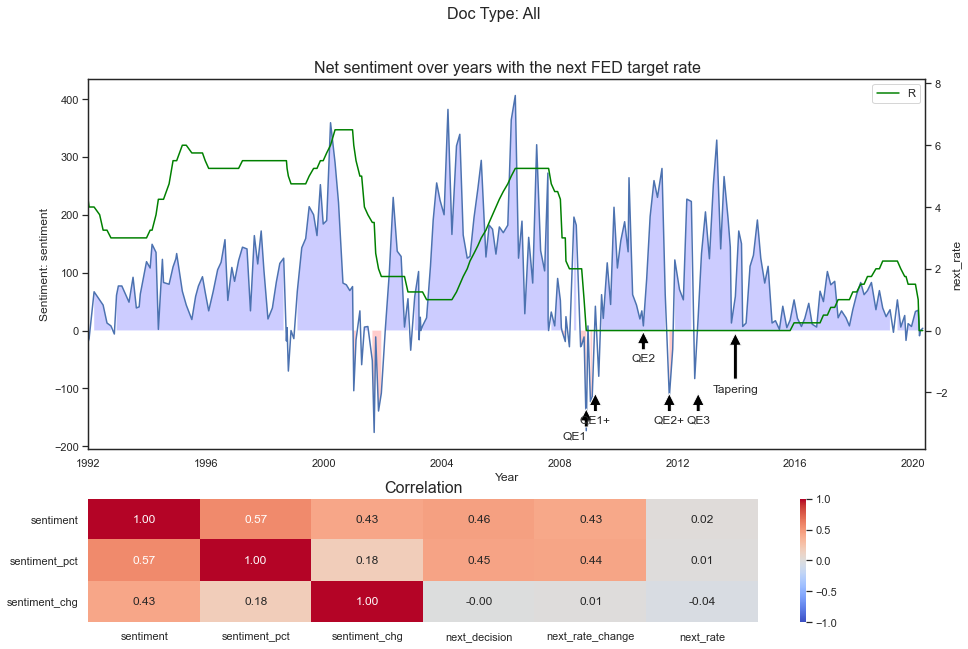

In [311]:
plot_sentiment(all_df, 'All', 'sentiment')

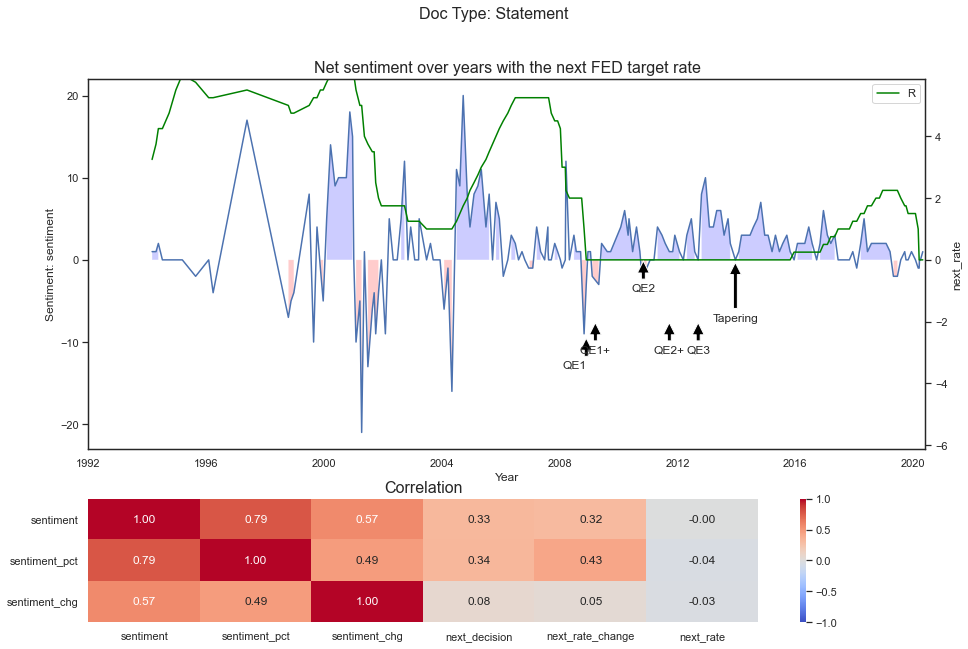

In [312]:
plot_sentiment(stmt_df, 'Statement', 'sentiment')

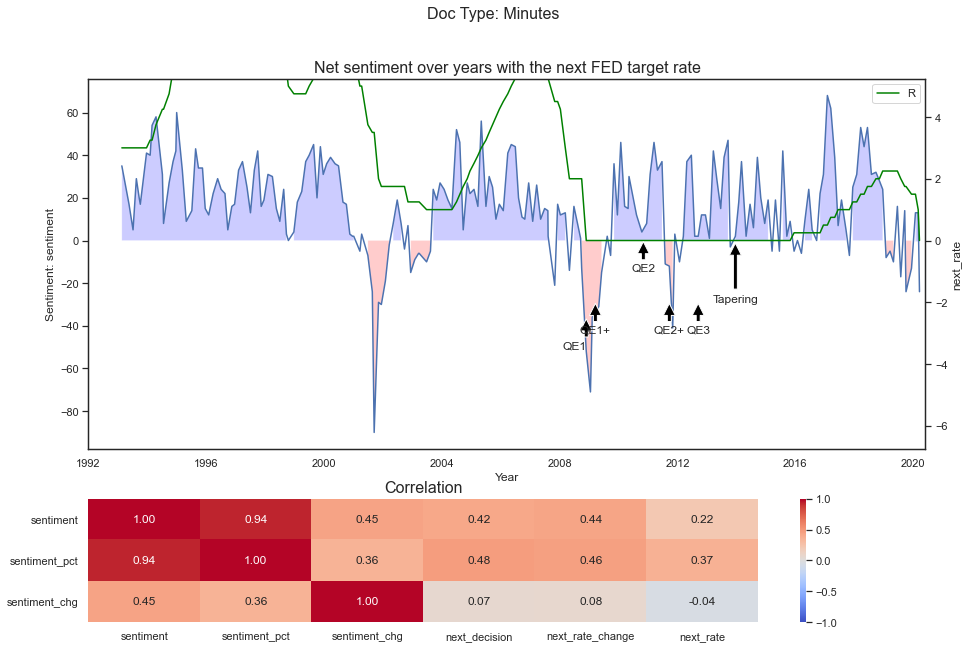

In [313]:
plot_sentiment(minutes_df, 'Minutes', 'sentiment')

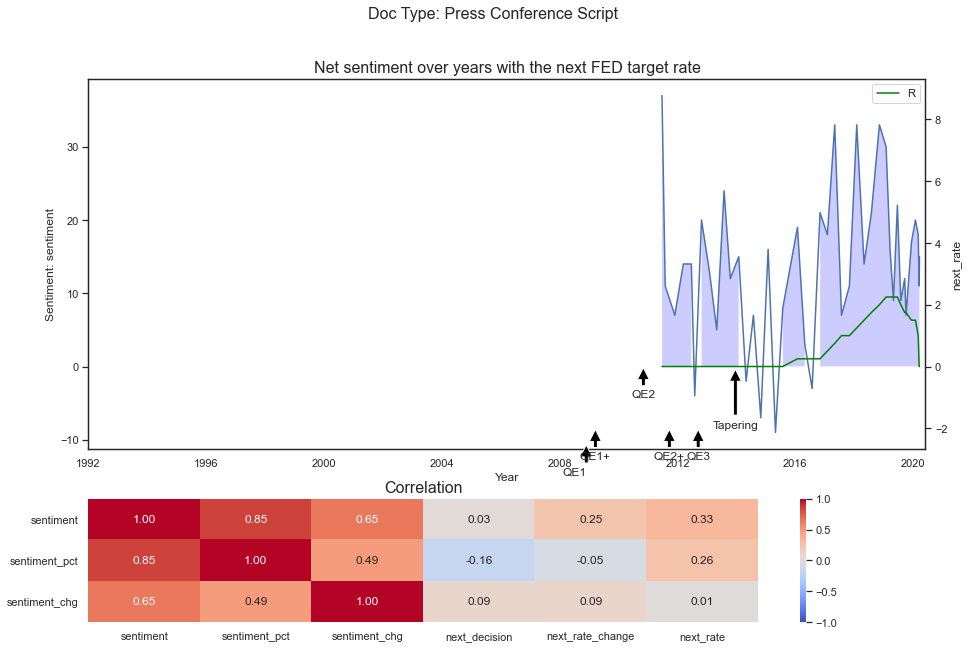

In [314]:
plot_sentiment(presconf_df, 'Press Conference Script', 'sentiment')

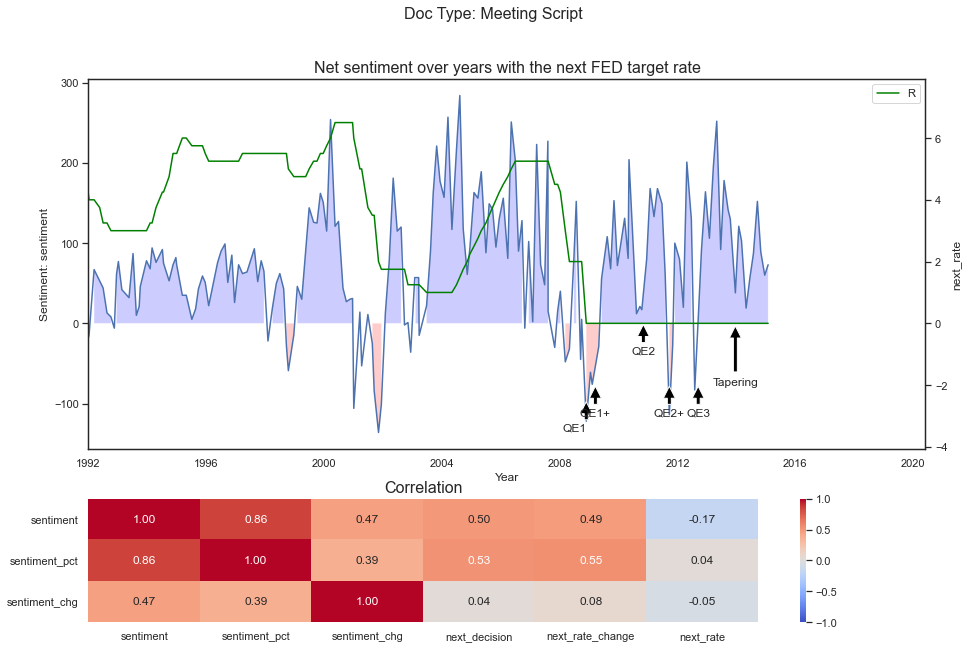

In [315]:
plot_sentiment(m_script_df, 'Meeting Script', 'sentiment')

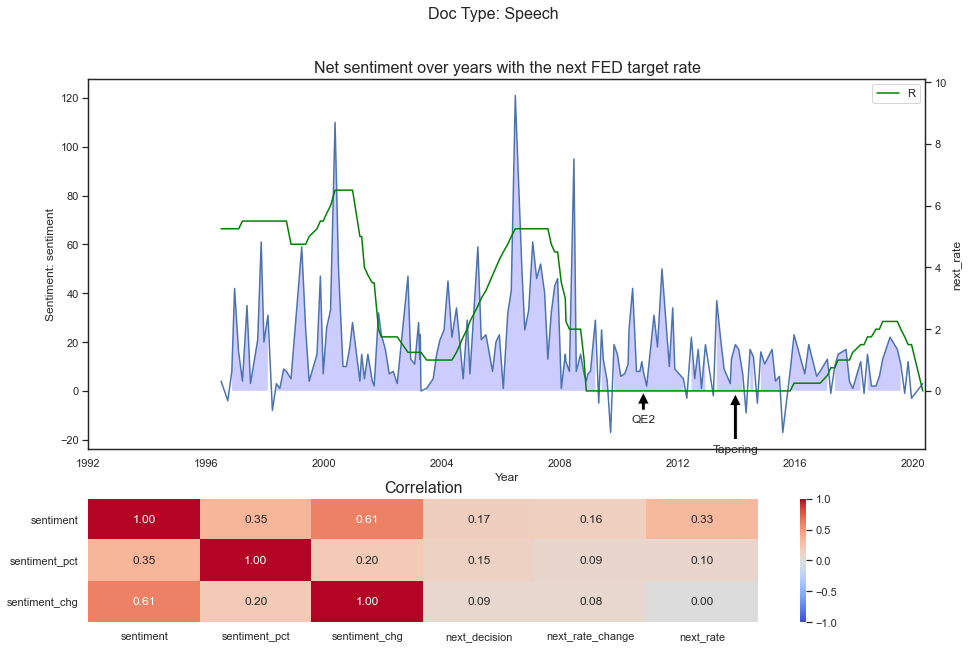

In [316]:
plot_sentiment(speech_df, 'Speech', 'sentiment')

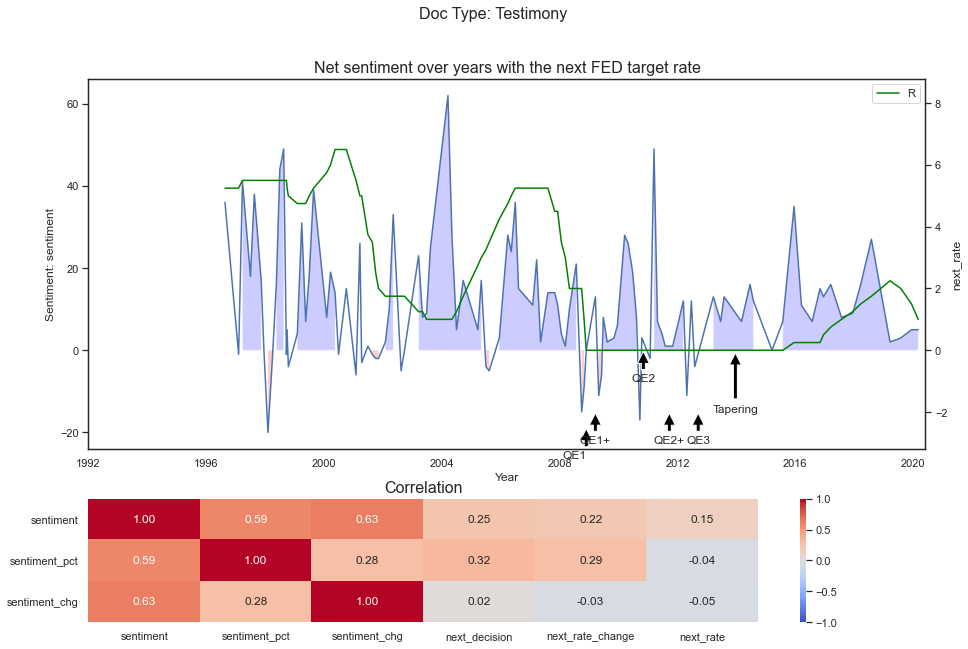

In [317]:
plot_sentiment(testimony_df, 'Testimony', 'sentiment')

# Save Data

In [34]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [35]:
# Save text data
save_data(result_df, 'fomc_sent_result_df')

In [282]:
save_data(all_df, 'fomc_sent_analized_all')